In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [44]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import itertools
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")

from os.path import join, exists, isfile, isdir
from os import makedirs, listdir

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}
matplotlib.rc('font', **font)

In [45]:
datasets = ["breast", "ads", "adult", "farm", "mnist17", "mnist49", "mnist56"]
experiments = ["baseline", "greedy_kernel", "landmarks_based"]

### Loading results

In [46]:
results_path = join(".", "results")
output_path = join(".", "results", "fig")
if not(exists(output_path)): makedirs(output_path)

In [47]:
def load_dir_results(dir_path):
    dir_results = []
    for f in [f for f in listdir(dir_path) if (isfile(join(dir_path, f)) and f.endswith(".pkl"))]:
        with open(join(dir_path, f), 'rb') as in_file:
            dir_results += pickle.load(in_file)
                
    for d in [d for d in listdir(dir_path) if isdir(join(dir_path, d))]:
        dir_results += load_dir_results(join(dir_path, d))
    
    return dir_results

def load_results(results_path):
    # Loading
    results = []
    for exp in set(listdir(results_path)).intersection(experiments):
        results += load_dir_results(join(results_path, exp))
    results = pd.DataFrame(results)
    return results

In [48]:
results_file = join(output_path, "results.pkl")
if not exists(results_file):
    results = load_results(results_path)
    with open(results_file, 'wb') as out_file:
        pickle.dump(results, out_file)
        
with open(results_file, 'rb') as in_file:
    results = pickle.load(in_file)
results = load_results(results_path)
results_per_dataset = {d:results.loc[results.dataset == d] for d in datasets}

# Greedy Kernel Learning

Populating the interactive namespace from numpy and matplotlib
breast


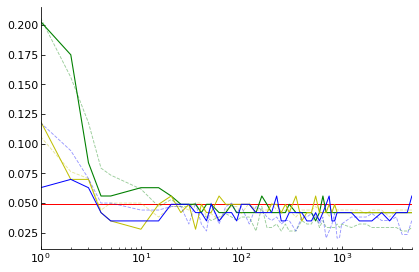

ads


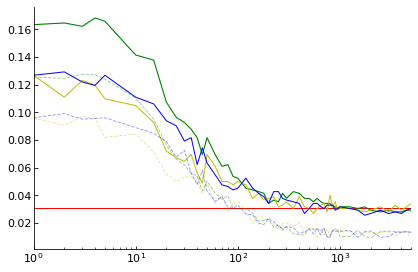

adult


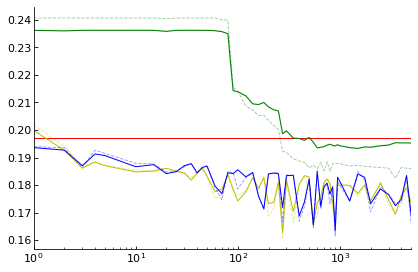

farm


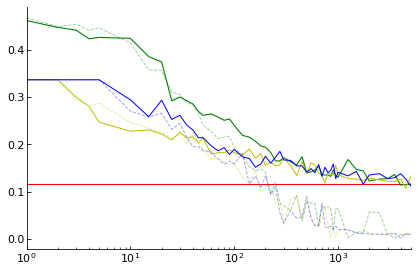

mnist17


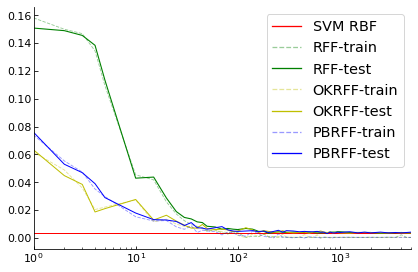

mnist49


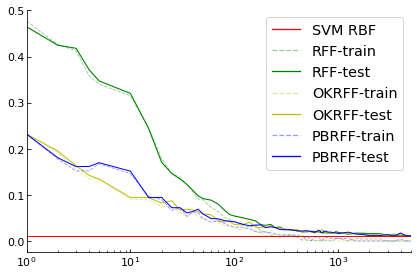

mnist56


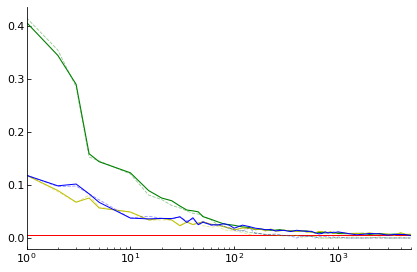

In [49]:
N = 20000
max_D = 5000

%pylab inline
pylab.rcParams['figure.figsize'] = (6, 4)
for d in datasets:
    print(d)
    r = results_per_dataset[d]

    # SVM
    svm_error = list(r.loc[r.algo == 'SVM']['test_error'])[0]
    plt.axhline(y=svm_error, color='r', linestyle='-', linewidth=1, label="SVM RBF")

    # RFF
    r_rff = r.loc[r.algo == 'RFF'].loc[r.D <= max_D].set_index('D')
    plt.semilogx(r_rff['train_error'], "--", label=f"RFF-train",color ='g', linewidth=0.9, alpha=0.4)
    plt.semilogx(r_rff['test_error'], "-", label=f"RFF-test", color ='g', linewidth=1.1)
    
    # Optimized Kernel RFF
    r_okrff = r.loc[r.algo == 'OKRFF'].loc[r.D <= max_D]
    r_okrff = r.loc[r_okrff.groupby(['D'])["val_error"].idxmin()].set_index('D')
    plt.semilogx(r_okrff['train_error'], "--", label=f"OKRFF-train", color ='y', linewidth=0.9,alpha=0.4)
    plt.semilogx(r_okrff['test_error'], "-", label=f"OKRFF-test", color ='y', linewidth=1)
    
    # PAC-Bayes RFF
    r_pbrff = r.loc[r.algo == 'PBRFF'].loc[r.D <= max_D].sort_values('beta', ascending=False)
    r_pbrff = r.loc[r_pbrff.groupby(['D'])["val_error"].idxmin()].set_index('D')
    plt.semilogx(r_pbrff['train_error'], "--", label=f"PBRFF-train", color ='b', linewidth=0.9,alpha=0.4)
    plt.semilogx(r_pbrff['test_error'], "-", label=f"PBRFF-test", color ='b', linewidth=1)
    
    sns.despine(top=True, right=True)
    if d in ["mnist49", "mnist17"]:
        leg = plt.legend(frameon=True, fontsize='x-large')
        leg_lines = leg.get_lines()
        plt.setp(leg_lines, linewidth=1.3)
    plt.tight_layout()
    plt.autoscale(enable=True, axis='x', tight=True)
    tick_params(axis='both', which='both', pad=2, direction='in', labelsize=11)
    plt.savefig(join(output_path, f"error_vs_features_{d}.pdf"))
    plt.show()

# Landmarks-Based Learning

####  Test error of the landmarks-based approach

In [50]:
landmarks_method = 'clustering'
perc_landmarks = 0.1
beta = 1
D = 64

### SVM ###
svm_results = pd.DataFrame(results.loc[results.algo == 'SVM'].set_index('dataset')['test_error'])\
                                                             .rename(columns={'test_error': 'svm'})

### RBF ###
rbf_results = pd.DataFrame(results.loc[(results.algo == 'RBF') & \
                                       (results.perc_landmarks == perc_landmarks) & \
                                       (results.method == landmarks_method)] \
                                       .set_index('dataset')['test_error']) \
                                       .rename(columns={'test_error': 'rbf'})

### PAC-Bayes ###
pb_results = results.loc[(results.algo == 'PB') & (results.perc_landmarks == perc_landmarks) & \
                         (results.method == landmarks_method)].sort_values('beta', ascending=True)

# beta and D optimized on validation set

pb_results_optimized = pd.DataFrame(pb_results.loc[pb_results.groupby(['method', 'perc_landmarks', 'dataset']) \
                                                  ["val_error"].idxmin()].set_index('dataset')['test_error']) \
                                                  .rename(columns={'test_error': 'pb'})

# beta fixed, D optimized on validation set
pb_results_beta = pb_results.loc[pb_results.beta == beta]
pb_results_beta = pd.DataFrame(pb_results_beta.loc[pb_results_beta.groupby(['method', 'perc_landmarks', 'dataset']) \
                                                  ["val_error"].idxmin()].set_index('dataset')['test_error'])\
                                                  .rename(columns={'test_error': 'pb_beta'})

# beta optimized on validation set, D fixed
pb_results_D = pb_results.loc[pb_results.D == D]
pb_results_D = pd.DataFrame(pb_results_D.loc[pb_results_D.groupby(['method', 'perc_landmarks', 'dataset']) \
                                            ["val_error"].idxmin()].set_index('dataset')['test_error']) \
                                            .rename(columns={'test_error': 'pb_D'})


table = svm_results.join(rbf_results).join(pb_results_optimized).join(pb_results_beta).join(pb_results_D)
table = (100*table).round(2).sort_index()
print(table.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &    svm &    rbf &     pb &  pb\_beta &   pb\_D \\
dataset &        &        &        &          &        \\
\midrule
ads     &   3.05 &  10.98 &   4.88 &     5.12 &   5.00 \\
adult   &  19.70 &  19.60 &  17.99 &    17.99 &  17.99 \\
breast  &   4.90 &   6.99 &   3.50 &     3.50 &   2.80 \\
farm    &  11.58 &  17.47 &  15.73 &    14.19 &  15.73 \\
mnist17 &   0.34 &   0.74 &   0.42 &     0.32 &   0.32 \\
mnist49 &   1.16 &   2.26 &   1.80 &     2.09 &   2.50 \\
mnist56 &   0.55 &   0.97 &   1.06 &     1.55 &   1.03 \\
\bottomrule
\end{tabular}



#### Behavior of the Landmarks-based approach according to the percentage of training points selected as landmarks

Populating the interactive namespace from numpy and matplotlib
Dataset: breast


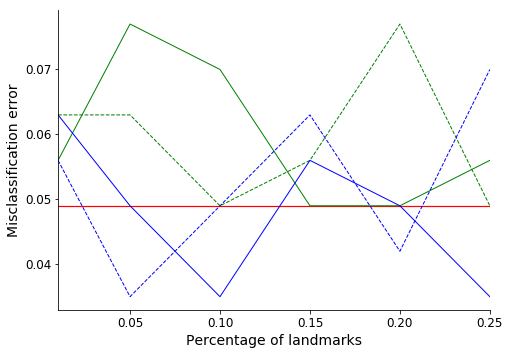

Dataset: ads


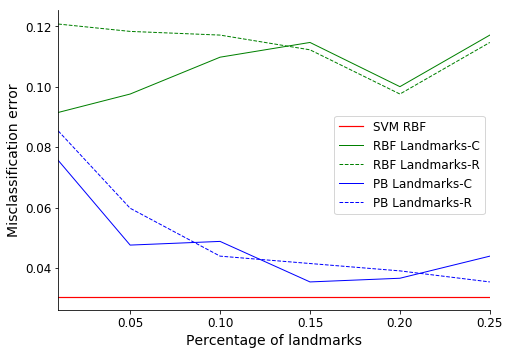

Dataset: adult


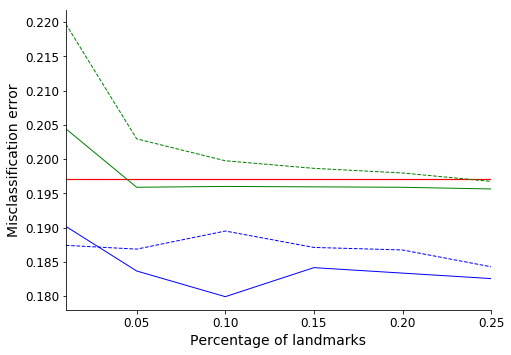

Dataset: farm


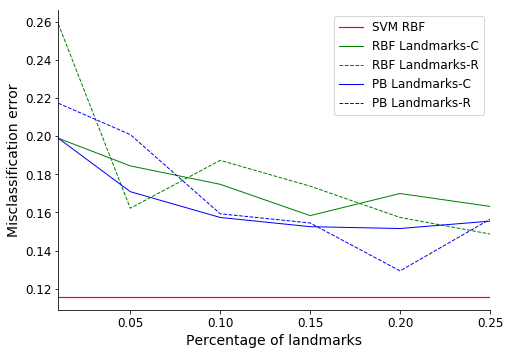

Dataset: mnist17


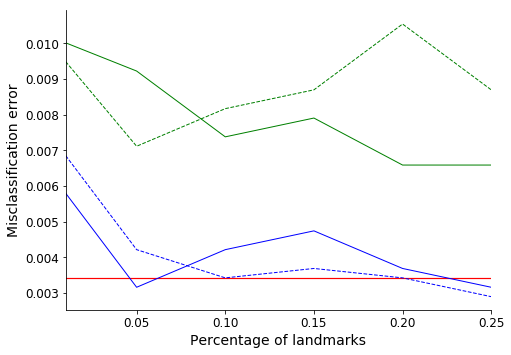

Dataset: mnist49


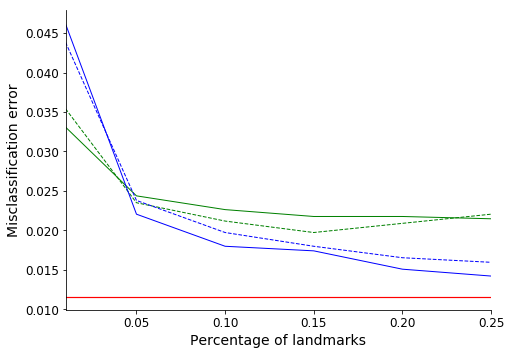

Dataset: mnist56


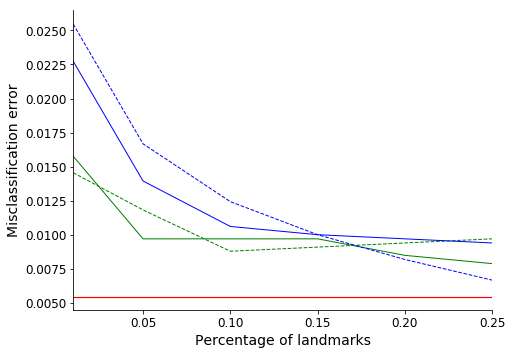

In [51]:
%pylab inline
pylab.rcParams['figure.figsize'] = (7, 5)
for d in datasets:
    print(f"Dataset: {d}")
    r = results_per_dataset[d]
    
    ### SVM ###
    svm_error = list(r.loc[r.algo == 'SVM']['test_error'])[0]
    plt.axhline(y=svm_error, color='r', linestyle='-', linewidth=1.2, label="SVM RBF")
    
    ### RBF ###
    r_rbf = r.loc[r.algo == 'RBF'].sort_values('perc_landmarks')
    for method in r_rbf.method.unique():
        plt.plot(r_rbf.loc[r_rbf.method == method].set_index(['perc_landmarks'])['test_error'], 
                 '--' if method == "random" else "-", 
                 label=f"RBF Landmarks" + ("-R" if method == "random" else "-C"),
                 color = 'g',
                 linewidth=1)
        
    ### PAC-Bayes ###
    r_pb = r.loc[r.algo == 'PB'].sort_values('perc_landmarks', ascending=False).sort_values('beta', ascending=True)

    # Selecting beta and D based on error on the validation set
    r_pb = r_pb.loc[r_pb.groupby(['method', 'perc_landmarks'])["val_error"].idxmin()]
    for method in r_pb.method.unique():
        plt.plot(r_pb.loc[r_pb.method == method].set_index(['perc_landmarks'])['test_error'], 
                 '--' if method == "random" else "-", 
                 label=f"PB Landmarks"  + ("-R" if method == "random" else "-C"),
                 color = 'b',
                 linewidth = 1)

    plt.xlabel("Percentage of landmarks", fontsize=14)
    plt.ylabel("Misclassification error", fontsize=14)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.tick_params(axis='both', which='both', pad=3, direction='out', labelsize=12)
    if d == "farm":
        plt.legend(frameon=True, fontsize='large')
    elif d == "ads":
        plt.legend(frameon=True, fontsize='large',loc=(0.64, 0.32))
    plt.savefig(join(output_path, f"error_landmarks_{d}.pdf"))
    plt.show()